In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchinfo
import torchtext.transforms as T
from seaborn import heatmap
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.common.schemas import NlpContext
from torchlake.sequence_data.models import LstmClassifier
from torchtext.datasets import CoNLL2000Chunking
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm

# setting


In [2]:
data_path = Path("../../data/CoNLL2000")
artifacts_path = Path("../../artifacts/bilstm")

In [3]:
batch_size = 128
context = NlpContext()

# data


In [4]:
def datapipe_factory(datapipe, text_transform=None, label_transform=None):
    datapipe = datapipe.map(
        lambda item: [[word.lower() for word in item[0]], item[1]]
    ).filter(lambda item: len(item[0]) > context.min_seq_len)

    if text_transform:
        datapipe = datapipe.map(lambda item: (text_transform(item[0]), item[1]))

    if label_transform:
        datapipe = datapipe.map(lambda item: (item[0], label_transform(item[1])))

    return datapipe

In [5]:
train_data, test_data = CoNLL2000Chunking(data_path.as_posix())

In [6]:
vocab = build_vocab_from_iterator(
    map(lambda it: it[0], train_data),
    specials=context.special_tokens,
    min_freq=context.min_frequency,
)

vocab.set_default_index(context.unk_idex)

In [7]:
label_vocab = build_vocab_from_iterator(
    map(lambda it: it[1], train_data),
    specials=context.special_tokens,
)

label_vocab.set_default_index(context.unk_idex)

In [8]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [9]:
label_transform = T.Sequential(
    T.VocabTransform(label_vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [10]:
def collate_fn(batch: list):
    text_placeholder, label_placeholder = [], []

    for row in batch:
        text, label = row[0], row[1]
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.stack(label_placeholder)

In [11]:
train_iter = DataLoader(
    datapipe_factory(train_data, text_transform, label_transform),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

test_iter = DataLoader(
    datapipe_factory(test_data, text_transform, label_transform),
    batch_size=batch_size,
    collate_fn=collate_fn,
)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [12]:
for text, label in train_iter:
    print(text.shape, label.shape)
    break

torch.Size([128, 256]) torch.Size([128, 256])


# model


In [13]:
vocab_size = len(vocab)
label_size = len(label_vocab)

In [14]:
device = torch.device(context.device)

In [17]:
model = LstmClassifier(
    vocab_size,
    128,
    128,
    label_size,
    padding_idx=context.padding_idx,
    bidirectional=True,
).to(device)

In [18]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
LstmClassifier                           --
├─Embedding: 1-1                         563,968
├─LSTM: 1-2                              264,192
├─LayerNorm: 1-3                         512
├─Linear: 1-4                            12,336
Total params: 841,008
Trainable params: 841,008
Non-trainable params: 0

# train


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [20]:
# Check predictions before training
with torch.no_grad():
    model.eval()
    for text, label in train_iter:
        print(model(text.to(device)).shape)
        break

torch.Size([128, 256, 48])


In [21]:
model.train()
for epoch in range(10):
    running_loss = 0.0

    dataset_count = 0
    for text, label in tqdm(train_iter):
        optimizer.zero_grad()

        text = text.to(device)
        label = label.to(device)

        output = model(text).permute(0, 2, 1)
        loss = criterion(output, label)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        dataset_count += text.size(0)

    print(f"epoch {epoch+1}: {running_loss/dataset_count}")

67it [00:05, 11.65it/s]


epoch 1: 0.0037460332708572274


67it [00:04, 15.62it/s]


epoch 2: 0.002896811743614389


67it [00:04, 15.41it/s]


epoch 3: 0.002646682853462981


67it [00:04, 14.07it/s]


epoch 4: 0.0024516941604218376


67it [00:04, 14.16it/s]


epoch 5: 0.0023008043210564263


67it [00:04, 15.30it/s]


epoch 6: 0.00218329049382748


67it [00:04, 15.42it/s]


epoch 7: 0.002090024280556436


67it [00:04, 15.31it/s]


epoch 8: 0.002015873708122813


67it [00:04, 15.75it/s]


epoch 9: 0.0019562145983522284


67it [00:04, 16.36it/s]

epoch 10: 0.0019041814671050925


# inference


In [28]:
with torch.no_grad():
    model.eval()

    confusion_matrix = IncrementalConfusionMatrix(label_size)
    for text, label in tqdm(train_iter):
        text = text.to(device)
        label = label.to(device)

        output = model(text).argmax(dim=2)

        confusion_matrix.update(
            label.view(-1).detach().cpu().numpy(),
            output.view(-1).detach().cpu().numpy(),
        )

    print(confusion_matrix)

67it [00:03, 18.32it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 67  0 ...  0  0  0]
 [ 0  0 67 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [50]:
accs = (confusion_matrix.matrix.diagonal() / confusion_matrix.matrix.sum(0)).round(2)
for label_name, acc in zip(label_vocab.get_itos(), accs):
    print(f"{label_name:<5}: {acc} %")

<unk>: 0.0 %
<bos>: 0.1 %
<eos>: 0.17 %
<pad>: 0.03 %
NN   : 0.04 %
IN   : 0.04 %
NNP  : 0.04 %
DT   : 0.05 %
NNS  : 0.07 %
JJ   : 0.09 %
,    : 0.05 %
.    : 0.08 %
CD   : 0.14 %
VBD  : 0.19 %
RB   : 0.14 %
VB   : 0.11 %
CC   : 0.16 %
TO   : 0.14 %
VBN  : 0.03 %
VBZ  : 0.24 %
PRP  : 0.47 %
VBG  : 0.01 %
VBP  : 0.03 %
MD   : 0.02 %
PRP$ : 0.0 %
POS  : 0.02 %
$    : 0.65 %
``   : 0.5 %
''   : 0.37 %
:    : 0.06 %
WDT  : 0.0 %
JJR  : 0.0 %
WP   : 0.0 %
WRB  : 0.0 %
NNPS : 0.0 %
JJS  : 0.0 %
RBR  : 0.0 %
)    : 0.0 %
(    : 0.0 %
EX   : 0.0 %
RBS  : 0.0 %
RP   : 0.0 %
PDT  : 0.0 %
FW   : 0.0 %
#    : 0.0 %
WP$  : 0.0 %
UH   : 0.0 %
SYM  : 0.0 %


<Axes: >

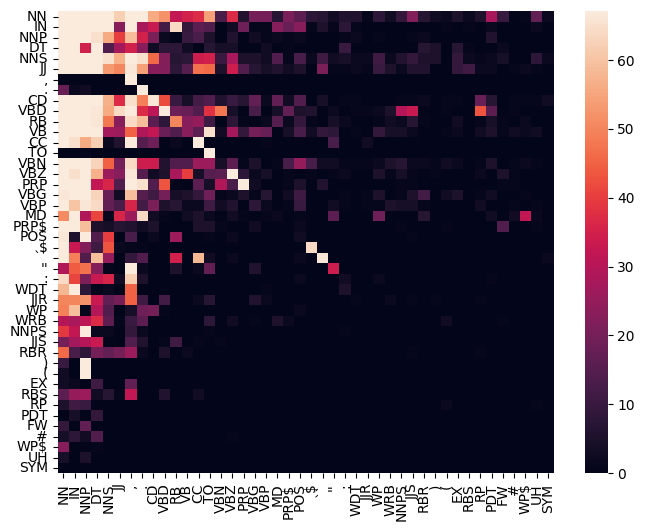

In [35]:
plt.figure(figsize=(8, 6))
heatmap(
    confusion_matrix.matrix[4:, 4:],
    xticklabels=label_vocab.get_itos()[4:],
    yticklabels=label_vocab.get_itos()[4:],
)